In [2]:
import pandas as pd
import numpy as np
from numba import jit
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.trading import TradingClient
from alpaca.trading.requests import GetCalendarRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.data.enums import Adjustment

from typing import List, Tuple, Optional

import matplotlib.pyplot as plt
from collections import defaultdict, deque
import numpy as np
import toml
import os
import math

from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo
from tqdm import tqdm


# Importing the modules themselves for reloading
import TradePosition
import TouchArea

# Reloading the modules to apply any changes
import importlib
importlib.reload(TradePosition)
importlib.reload(TouchArea)

from TradePosition import TradePosition, SubPosition, export_trades_to_csv
from TouchArea import TouchArea, TouchAreaCollection

from dotenv import load_dotenv

ny_tz = ZoneInfo("America/New_York")
STANDARD_DATETIME_STR = '%Y-%m-%d %H:%M:%S'
ROUNDING_DECIMAL_PLACES = 10  # Choose an appropriate number of decimal places

load_dotenv(override=True)
livepaper = os.getenv('LIVEPAPER')
config = toml.load('../config.toml')

# Replace with your Alpaca API credentials
API_KEY = config[livepaper]['key']
API_SECRET = config[livepaper]['secret']


trading_client = TradingClient(API_KEY, API_SECRET)

In [3]:
def is_security_marginable(symbol: str) -> bool:
    try:
        asset = trading_client.get_asset(symbol)
        return asset.marginable
    except Exception as e:
        print(f"Error checking marginability for {symbol}: {e}")
        return False
    
# # testing purposes
# def is_security_marginable(symbol: str) -> bool:
#     marginable_symbols = {'NVDA', 'MSFT', 'AAPL', 'TJX', 'JNJ', 'AMZN', 'TSLA', 'AZN'}
#     return symbol in marginable_symbols

# for symbol in {'NVDA', 'MSFT', 'AAPL', 'TJX', 'JNJ', 'AMZN', 'TSLA', 'AZN'}:
#     print(symbol, is_security_marginable(symbol))

In [4]:
def get_market_hours(dates):
    """
    Parameters:
    dates (list of str): List of dates in 'YYYY-MM-DD' format.

    Returns:
    
    dict: Dictionary with dates as keys and (market_open, market_close) tuples as values.
    """
    start_date = min(dates)
    end_date = max(dates)
    
    calendar_request = GetCalendarRequest(start=start_date, end=end_date)
    calendar = trading_client.get_calendar(calendar_request)
    
    market_hours = {str(day.date): (day.open.replace(tzinfo=ny_tz), day.close.replace(tzinfo=ny_tz)) for day in calendar}
    return market_hours

In [5]:
def calculate_dynamic_levels(df:pd.DataFrame, ema_short=9, ema_long=20):
    """
    Calculate VWAP and EMAs for the dataframe.
    
    :param df: DataFrame with 'close', 'high', 'low', and 'volume' columns
    :param ema_short: Period for the short EMA (default 9)
    :param ema_long: Period for the long EMA (default 20)
    :return: DataFrame with additional columns for VWAP and EMAs
    """
    
    assert 'vwap' in df.columns
    
    # Calculate EMAs
    # df[f'EMA{ema_short}'] = df['close'].ewm(span=ema_short, adjust=False).mean()
    # df[f'EMA{ema_long}'] = df['close'].ewm(span=ema_long, adjust=False).mean()
    
    # Calculate a combined central value
    # df['central_value'] = (df['vwap'] + df[f'EMA{ema_short}'] + df[f'EMA{ema_long}']) / 3
    # df['central_value'] = df['vwap']
    # df['central_value'] = df[f'EMA{ema_short}']
    # df['central_value'] = df[f'EMA{ema_long}']
    
    # 1
    # df['central_value'] = df['close'].ewm(span=26, adjust=True).mean()
    
    # 2
    # df['central_value'] = df['close'].ewm(span=26, adjust=False).mean()
    
    # 3
    # halflife = '26min'  # 26 minutes
    # df['central_value'] = df['close'].ewm(
    #     halflife=halflife,
    #     times=df.index.get_level_values('timestamp'),
    #     adjust=True
    # ).mean()

    # #4
    # span = 26 # span of 26 = 9.006468342000588min
    # alpha = 2 / (span + 1)
    # halflife = np.log(2) / np.log(1 / (1 - alpha))
    # halflife_str = f"{halflife}min"

    # df['central_value'] = df['close'].ewm(
    #     halflife=halflife_str,
    #     times=df.index.get_level_values('timestamp'),
    #     adjust=True
    # ).mean()
    
    #45
    span = 26 # span of 26 = 9.006468342000588min
    alpha = 2 / (span + 1)
    halflife = np.log(2) / np.log(1 / (1 - alpha))
    halflife_str = f"{halflife}min"

    df['central_value'] = df['close'].ewm(
        halflife=halflife_str,
        times=df.index.get_level_values('timestamp'),
        adjust=True
    ).mean()
    df['central_value'] = (df['vwap'] + df['central_value']*2) / 3

In [6]:
@jit(nopython=True)
def process_touches(touches, prices, touch_area_lower, touch_area_upper, level, level_lower_bound, level_upper_bound, is_long, min_touches):
    consecutive_touches = np.full(min_touches, -1, dtype=np.int64)
    count = 0
    prev_price = None
    for i in range(len(prices)):
        price = prices[i]
        is_touch = (prev_price is not None and 
                    ((prev_price < level <= price) or (prev_price > level >= price)) or 
                    (price == level))
        
        if level_lower_bound <= price <= level_upper_bound:
            if is_touch:
                consecutive_touches[count] = touches[i]
                count += 1
                if count == min_touches:
                    return consecutive_touches
        else:
            buy_price = touch_area_upper if is_long else touch_area_lower
            if (is_long and price > buy_price) or (not is_long and price < buy_price):
                consecutive_touches[:] = -1
                count = 0
        
        prev_price = price
    return np.empty(0, dtype=np.int64)  # Return empty array instead of empty list

def calculate_touch_area(levels_by_date, is_long, df, symbol, market_hours, min_touches, bid_buffer_pct, use_median, touch_area_width_agg, multiplier, start_time, end_time):
    current_id = 0
    touch_areas = []
    widths = []


    for date, levels in tqdm(levels_by_date.items()):
        market_open, market_close = market_hours.get(str(date), (None, None))
        if market_open and market_close:
            date_obj = datetime.combine(date, datetime.min.time()).replace(tzinfo=ny_tz)
            if start_time:
                day_start_time = date_obj.replace(hour=start_time.hour, minute=start_time.minute)
            else:
                day_start_time = market_open

            if end_time:
                day_end_time = min(date_obj.replace(hour=end_time.hour, minute=end_time.minute), market_close - timedelta(minutes=3))
            else:
                day_end_time = market_close - timedelta(minutes=3)
                
        else:
            # print('Hours not available. Skipping',date)
            continue
        
        day_data = df[df.index.get_level_values('timestamp').date == date]
        day_timestamps = day_data.index.get_level_values('timestamp')
        day_timestamps_np = day_timestamps.astype(np.int64)  # Convert to nanoseconds
        day_prices = day_data['close'].values
        day_atr = day_data['MTR' if use_median else 'ATR'].values

        for (level_lower_bound, level_upper_bound, level), touches in levels.items():
            if len(touches) < min_touches:
                continue
            
            touch_timestamps_np = np.array([t.replace(tzinfo=ny_tz).timestamp() * 1e9 for t in touches], dtype=np.int64)  # Convert to nanoseconds
            touch_indices = np.searchsorted(day_timestamps_np, touch_timestamps_np)
            
            touch_area_width = touch_area_width_agg(day_atr[touch_indices]) * multiplier

            if touch_area_width is None or np.isnan(touch_area_width) or touch_area_width <= 0:
                continue
            
            widths.append(touch_area_width)
            
            # SUBJECt TO CHANGE
            touch_area_lower = level - (2 * touch_area_width / 3) if is_long else level - (1 * touch_area_width / 3)
            touch_area_upper = level + (1 * touch_area_width / 3) if is_long else level + (2 * touch_area_width / 3)
            
            # touch_area_lower = level - (1 * touch_area_width / 3) if is_long else level - (2 * touch_area_width / 3)
            # touch_area_upper = level + (2 * touch_area_width / 3) if is_long else level + (1 * touch_area_width / 3)
            
            # touch_area_lower = level - (1 * touch_area_width / 2) if is_long else level - (1 * touch_area_width / 2)
            # touch_area_upper = level + (1 * touch_area_width / 2) if is_long else level + (1 * touch_area_width / 2)
            
            
            valid_mask = (day_timestamps[touch_indices] >= day_start_time) & (day_timestamps[touch_indices] < day_end_time)
            # valid_mask = (day_timestamps[touch_indices] < day_end_time)
            
            valid_touch_indices = touch_indices[valid_mask]
            valid_prices = day_prices[valid_touch_indices]
            
            consecutive_touch_indices = process_touches(
                valid_touch_indices, 
                valid_prices,
                touch_area_lower, 
                touch_area_upper,  
                level, 
                level_lower_bound,
                level_upper_bound, 
                is_long, 
                min_touches
            )
            
            if len(consecutive_touch_indices) == min_touches:
                consecutive_touches = day_timestamps[consecutive_touch_indices[consecutive_touch_indices != -1]]
                touch_area = TouchArea(
                    id=current_id,
                    level=level,
                    upper_bound=touch_area_upper,
                    lower_bound=touch_area_lower,
                    touches=[t.replace(tzinfo=ny_tz) for t in consecutive_touches.tolist()],
                    is_long=is_long,
                    min_touches=min_touches,
                    bid_buffer_pct=bid_buffer_pct
                )
                touch_areas.append(touch_area)
                current_id += 1

    return touch_areas, widths

In [7]:
def calculate_touch_detection_area(symbol, start_date, end_date, atr_period=10, multiplier=2, min_touches=2, bid_buffer_pct=0.005, start_time=None, end_time=None, use_median=False, \
    touch_area_width_agg=np.median, use_saved_bars=False, export_bars_path=None):
    """
    Calculates touch detection areas for a given stock symbol based on historical price data and volatility.

    Parameters:
    symbol (str): The stock symbol to analyze.
    start_date (str|datetime): The start date for historical data. Format: 'YYYY-MM-DD HH:MM:SS'
    end_date (str|datetime): The end date for historical data. Format: 'YYYY-MM-DD HH:MM:SS'
    atr_period (int): The period for calculating Average True Range (ATR). Default is 10.
    multiplier (float): The multiplier for ATR to define the touch detection area width. Default is 2.
    min_touches (int): The minimum number of touches required to consider a level as significant. Default is 2.
    bid_buffer_pct (float): The percentage buffer for bid prices. Default is 0.005 (0.5%).
    start_time (str): The earliest time to consider for touches each day. Format: 'HH:MM'. If None, uses market open.
    end_time (str): The latest time to consider for touches each day. Format: 'HH:MM'. If None, uses market close minus 3 minutes.
    use_median (bool): If True, uses median instead of mean for calculations. Default is False.
    touch_area_width_agg (function): Aggregation function for calculating touch area width. Default is np.median.
    use_saved_bars (bool): If True, uses previously saved price data. Default is False.
    export_bars_path (str): Path to export or import price data. Default is None.

    Returns:
    dict: A dictionary containing:
        - 'symbol': The analyzed stock symbol
        - 'long_touch_area': List of TouchArea objects for long positions
        - 'short_touch_area': List of TouchArea objects for short positions
        - 'market_hours': Dictionary of market hours for each trading day
        - 'bars': DataFrame of price data
        - 'mask': Boolean mask for filtering data
        - 'bid_buffer_pct': The bid buffer percentage used
        - 'min_touches': The minimum number of touches used
        - 'start_time': The start time used for analysis
        - 'end_time': The end time used for analysis
        - 'use_median': Whether median was used instead of mean

    This function analyzes historical price data to identify significant price levels (support and resistance)
    based on the frequency of price touches. It considers market volatility using ATR and allows for 
    customization of the analysis parameters. The resulting touch areas can be used for trading strategies
    or further market analysis.
    """
    assert end_date > start_date
    
    # Inputed datetime strings are in EST
    if isinstance(start_date, str):
        start_date = datetime.strptime(start_date, STANDARD_DATETIME_STR).replace(tzinfo=ny_tz)
    if isinstance(end_date, str):
        end_date = datetime.strptime(end_date, STANDARD_DATETIME_STR).replace(tzinfo=ny_tz)
    start_date_utc = start_date.astimezone(ZoneInfo("UTC"))
    end_date_utc = end_date.astimezone(ZoneInfo("UTC"))
        
    # Alpaca API setup
    client = StockHistoricalDataClient(api_key=API_KEY, secret_key=API_SECRET)

    # Request historical data
    if use_saved_bars and export_bars_path and os.path.isfile(export_bars_path):
        df = pd.read_csv(export_bars_path)
        df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
        df.set_index(['symbol', 'timestamp'], inplace=True)
    else:
        
        request_params = StockBarsRequest(
            symbol_or_symbols=symbol, # CAN be str or list. but set up for str (1 stock) for now)
            timeframe=TimeFrame.Minute,
            start=start_date_utc,
            end=end_date_utc,
            adjustment=Adjustment.ALL,
            # feed='iex'
        )
        bars = client.get_stock_bars(request_params)
        df = bars.df
        print(df.index.get_level_values('timestamp'))
        df.index = df.index.set_levels(
            pd.Series(df.index.get_level_values('timestamp').to_list()).dt.tz_convert(ny_tz),
            level='timestamp'
        )
        print(df.index.get_level_values('timestamp'))
        df.sort_index(inplace=True)
        if export_bars_path:
            df.reset_index().to_csv(export_bars_path,index=False)
        
        
    timestamps = df.index.get_level_values('timestamp')
    # print(timestamps)
    # print(df.columns)
    # print(df.dtypes)
    # print(df.head())
    
    # calculate_dynamic_levels(df, ema_short=9, ema_long=30) # default
    calculate_dynamic_levels(df)

    
    # Calculate True Range (TR)
    df['H-L'] = df['high'] - df['low']
    df['H-PC'] = np.abs(df['high'] - df['close'].shift(1))
    df['L-PC'] = np.abs(df['low'] - df['close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=atr_period).mean()
    df['MTR'] = df['TR'].rolling(window=atr_period).median()
    
    
    # Group data by date
    grouped = df.groupby(timestamps.date)
    
    all_support_levels = defaultdict(dict)
    all_resistance_levels = defaultdict(dict)

    def classify_level(level_items, index, day_df):
        return 'resistance' if level_items > day_df.loc[index, 'central_value'] else 'support'
    
    for date, day_df in tqdm(grouped):
        day_timestamps = day_df.index.get_level_values('timestamp')
        
        potential_levels = defaultdict(list)
        w_prev = 0
        
        for i in range(len(day_df)):
            high = day_df['high'].iloc[i]
            low = day_df['low'].iloc[i]
            close = day_df['close'].iloc[i]
            timestamp = day_timestamps[i]
            
            w = (high - low) / 2
            if w == 0:
                w = w_prev
            if w == 0:
                continue
            
            w_prev = w
            
            x = close - w
            y = close + w
            
            # Add this point to its own level
            potential_levels[(x, y)].append(timestamp)
            
            # Check if this point falls within any existing levels
            for (level_x, level_y), touches in potential_levels.items():
                if level_x <= close <= level_y and (level_x, level_y) != (x, y):
                    touches.append(timestamp)

        # Filter for strong levels
        strong_levels = {level: touches for level, touches in potential_levels.items() if len(touches) >= min_touches}

        # Classify levels as support or resistance
        for level, touches in strong_levels.items():
            initial_timestamp = touches[0]
            initial_close = day_df.loc[(symbol, initial_timestamp), 'close']

            classification = classify_level(day_df.loc[(symbol, initial_timestamp), 'close'].item(), (symbol, initial_timestamp), day_df)

            if classification == 'support':
                all_support_levels[date][(level[0], level[1], initial_close)] = touches
            else:
                all_resistance_levels[date][(level[0], level[1], initial_close)] = touches

    
    unique_dates = pd.unique(timestamps.date)
    date_strs = [str(date) for date in unique_dates]
    market_hours = get_market_hours(date_strs)
    
    if end_time:
        end_time = datetime.strptime(end_time, '%H:%M').time()
    if start_time:
        start_time = datetime.strptime(start_time, '%H:%M').time()
    
    long_touch_area, long_widths = calculate_touch_area(
        all_resistance_levels, True, df, symbol, market_hours, min_touches, 
        bid_buffer_pct, use_median, touch_area_width_agg, multiplier, start_time, end_time
    )
    short_touch_area, short_widths = calculate_touch_area(
        all_support_levels, False, df, symbol, market_hours, min_touches, 
        bid_buffer_pct, use_median, touch_area_width_agg, multiplier, start_time, end_time
    )
    
    # widths = long_widths + short_widths

    # might not need to mask out before market_open
    final_mask = pd.Series(False, index=df.index)
    for date in unique_dates:
        market_open, market_close = market_hours.get(str(date), (None, None))
        date = datetime.combine(date, datetime.min.time()).replace(tzinfo=ny_tz)
        if market_open and market_close:
            if start_time:
                day_start_time = date.replace(hour=start_time.hour, minute=start_time.minute)
            else:
                day_start_time = market_open
            if end_time:
                day_end_time = min(date.replace(hour=end_time.hour, minute=end_time.minute), market_close - timedelta(minutes=3))
            else:
                day_end_time = market_close - timedelta(minutes=3)
        else:
            day_start_time, day_end_time = date, date

        mask = (timestamps >= day_start_time) & (timestamps <= day_end_time)
        final_mask |= mask

    return {
        'symbol': symbol,
        'long_touch_area': long_touch_area,
        'short_touch_area': short_touch_area,
        'market_hours': market_hours,
        'bars': df,
        'mask': final_mask,
        'bid_buffer_pct': bid_buffer_pct,
        'min_touches': min_touches,
        'start_time': start_time,
        'end_time': end_time,
        'use_median': use_median
    }


In [8]:
def plot_touch_detection_areas(touch_detection_areas, zoom_start_date, zoom_end_date, save_path=None):
    """
    Visualizes touch detection areas and price data on a chart.

    Parameters:
    touch_detection_areas (dict): Dictionary containing touch areas and market data.
    zoom_start_date (str): Start date for the zoomed view. Format: 'YYYY-MM-DD HH:MM:SS'
    zoom_end_date (str): End date for the zoomed view. Format: 'YYYY-MM-DD HH:MM:SS'
    save_path (str, optional): Path to save the plot as an image file. Default is None.

    This function creates a plot showing the price movement, central value, and touch detection areas
    for both long and short positions. It highlights important points and areas on the chart,
    focusing on the specified date range. The resulting plot can be displayed and optionally saved.
    """
    symbol = touch_detection_areas['symbol']
    long_touch_area = touch_detection_areas['long_touch_area']
    short_touch_area = touch_detection_areas['short_touch_area']
    market_hours = touch_detection_areas['market_hours']
    df = touch_detection_areas['bars']
    mask = touch_detection_areas['mask']
    bid_buffer_pct = touch_detection_areas['bid_buffer_pct']
    min_touches = touch_detection_areas['min_touches']
    start_time = touch_detection_areas['start_time']
    end_time = touch_detection_areas['end_time']
    use_median = touch_detection_areas['use_median']

        
    plt.figure(figsize=(14, 7))
    plt.plot(df.index.get_level_values('timestamp'), df['central_value'], label='central_value', color='yellow')
    plt.plot(df.index.get_level_values('timestamp'), df['close'], label='Close Price', color='blue')

    df = df[mask]
    timestamps = df.index.get_level_values('timestamp')

    # Prepare data structures for combined plotting
    scatter_data = defaultdict(lambda: defaultdict(list))
    fill_between_data = defaultdict(list)
    line_data = defaultdict(list)

    def find_area_end_idx(start_idx, area:TouchArea, day_start_time, day_end_time):
        assert day_start_time.tzinfo == ny_tz and day_end_time.tzinfo == ny_tz
        entry_price = area.get_buy_price
        
        for i in range(start_idx + 1, len(df)):
            current_time = timestamps[i].replace(tzinfo=ny_tz)
            if current_time >= day_end_time:
                return i
            current_price = df['close'].iloc[i]
            
            if current_time >= area.get_min_touch_time:
                if area.is_long and current_price >= entry_price:
                    return i
                elif not area.is_long and current_price <= entry_price:
                    return i
        
        return len(df) - 1  # If no end condition is met, return the last index
    
    
    def process_area(area: TouchArea):
        if not area.is_active:
            return
        
        mark_pos = area.get_buy_price
        mark_shape = "v" if area.is_long else '^'
        color = 'red' if area.is_long else 'green'

        
        current_date = None
        for i, touch_time in enumerate(area.touches):
            touch_time = touch_time.astimezone(ny_tz)
            if touch_time in timestamps:
                start_idx = timestamps.get_loc(touch_time)
                
                if timestamps[start_idx].date() != current_date:
                    current_date = timestamps[start_idx].date()
                    market_open, market_close = market_hours.get(str(current_date), (None, None))
                    if market_open and market_close:
                        date_obj = datetime.combine(current_date, datetime.min.time()).replace(tzinfo=ny_tz)
                        if start_time:
                            day_start_time = date_obj.replace(hour=start_time.hour, minute=start_time.minute)
                        else:
                            day_start_time = market_open
                        if end_time:
                            day_end_time = min(date_obj.replace(hour=end_time.hour, minute=end_time.minute), market_close - timedelta(minutes=3))
                        else:
                            day_end_time = market_close - timedelta(minutes=3)
                    else:
                        # print('Hours not available. Skipping',date)
                        continue
                            
                            
                
                end_idx = find_area_end_idx(start_idx, area, day_start_time, day_end_time)
                x1 = [timestamps[start_idx].replace(tzinfo=ny_tz), area.get_min_touch_time]
                x2 = [area.get_min_touch_time, timestamps[end_idx].replace(tzinfo=ny_tz)]
                
                if timestamps[end_idx].replace(tzinfo=ny_tz) >= day_end_time:
                    continue
                scatter_color = 'gray' if i != min_touches - 1 else 'red' if end_idx == start_idx else 'blue'
                scatter_data[scatter_color][mark_shape].append((touch_time, mark_pos))
                
                if i == 0:  # first touch
                    fill_between_data[color].append((x1 + x2, [area.lower_bound] * 4, [area.upper_bound] * 4))
                    line_data['blue_alpha'].append((x1, [area.level] * 2))
                    line_data['blue'].append((x2, [area.level] * 2))

    for area in tqdm(long_touch_area + short_touch_area):
        process_area(area)

    # Plot combined data
    for color, shape_data in scatter_data.items():
        for shape, points in shape_data.items():
            if points:
                x, y = zip(*points)
                plt.scatter(x, y, color=color, s=12, marker=shape)

    for color, data in fill_between_data.items():
        for x, lower, upper in data:
            plt.fill_between(x[:2], lower[:2], upper[:2], color=color, alpha=0.1)
            plt.fill_between(x[2:], lower[2:], upper[2:], color=color, alpha=0.25)

    for color, data in line_data.items():
        for x, y in data:
            if color == 'blue_alpha':
                plt.plot(x, y, color='blue', linestyle='-', alpha=0.20)
            else:
                plt.plot(x, y, color='blue', linestyle='-')

    plt.title(f'{symbol} Price Chart with Touch Detection Areas')
    plt.xlabel('Date')
    plt.ylabel('Price')
    # plt.legend(['Close Price', 'Long Touch Area', 'Short Touch Area'])
    plt.legend().remove()
    plt.grid(True)
    
    zstart = datetime.strptime(zoom_start_date, STANDARD_DATETIME_STR).replace(tzinfo=ny_tz)
    zend = datetime.strptime(zoom_end_date, STANDARD_DATETIME_STR).replace(tzinfo=ny_tz)
    
    print(zstart, zend)

    plt.xlim(max(zstart, timestamps[0]), min(zend, timestamps[-1]))

    ymin, ymax = 0, -1
    for i in range(len(timestamps)):
        if timestamps[i] >= zstart:
            print(timestamps[i])
            ymin = i-1
            break
    for i in range(len(timestamps)):
        if timestamps[i] >= zend:
            print(timestamps[i])
            ymax = i
            break
    ys = df['close'].iloc[max(ymin, 0):min(ymax, len(df))]
    plt.ylim(min(ys),max(ys))
    
    if save_path:
        plt.savefig(save_path)

    plt.show()

In [9]:
# Use the decimal module:
# For financial calculations where precision is crucial, consider using Python's decimal module, which provides exact decimal representations and arithmetic.
# https://docs.python.org/3/library/decimal.html

# from decimal import *
# getcontext()
# # Decimal(3.14)

In [27]:
def backtest_strategy(touch_detection_areas, initial_investment: float=10000, do_longs=True, do_shorts=True, use_margin=False, times_buying_power=4, \
    min_stop_dist_relative_change_for_partial:Optional[int]=0, soft_start_time:Optional[str]=None, soft_end_time:Optional[str]=None, export_trades_path:Optional[str]=None):
    """
    Backtests a trading strategy based on touch detection areas, simulating trades and tracking performance.

    Parameters:
    touch_detection_areas (dict): Dictionary containing touch detection areas and other market data.
    initial_investment (float): The initial capital to start the backtest with. Default is 10000.
    do_longs (bool): Whether to execute long trades. Default is True.
    do_shorts (bool): Whether to execute short trades. Default is True.
    use_margin (bool): Whether to use margin for trading. Default is False.
    times_buying_power (float): The multiplier for buying power, up to the maximum of 4x allowed by Alpaca. Default is 4.
    min_stop_dist_relative_change_for_partial (Optional[int]): Minimum relative change in stop distance to trigger a partial trade. Default is 0.
    soft_start_time (Optional[str]): The earliest time to start trading each day. Format: 'HH:MM'. Default is None.
    soft_end_time (Optional[str]): Time after which no new positions are opened, but existing positions can be closed. Format: 'HH:MM'. Default is None.
    export_trades_path (Optional[str]): File path to export trade data. Default is None.

    Returns:
    tuple: A tuple containing various performance metrics and statistics from the backtest,
           including final balance, number of trades, win rate, and transaction costs.

    This function simulates trading based on the provided touch detection areas, applying the specified
    strategy parameters. It handles position entry and exit, manages risk, and calculates various
    performance metrics. The function supports both long and short trades, margin trading up to 4x as 
    per Alpaca's limits, and allows for partial position sizing based on price movements relative to 
    the touch areas. After the soft_end_time, the strategy only allows for closing existing positions.
    """
    
    symbol = touch_detection_areas['symbol']
    long_touch_area = touch_detection_areas['long_touch_area']
    short_touch_area = touch_detection_areas['short_touch_area']
    market_hours = touch_detection_areas['market_hours']
    df = touch_detection_areas['bars']
    mask = touch_detection_areas['mask']
    # bid_buffer_pct = touch_detection_areas['bid_buffer_pct']
    min_touches = touch_detection_areas['min_touches']
    start_time = touch_detection_areas['start_time']
    end_time = touch_detection_areas['end_time']
    # use_median = touch_detection_areas['use_median']

    if soft_start_time:
        soft_start_time = datetime.strptime(soft_start_time, '%H:%M').time()
    if soft_end_time:
        soft_end_time = datetime.strptime(soft_end_time, '%H:%M').time()
        
    debug = False
    debug2 = False
    def debug_print(*args, **kwargs):
        if debug:
            print(*args, **kwargs)
    def debug2_print(*args, **kwargs):
        if debug2:
            print(*args, **kwargs)
            
    assert do_longs or do_shorts
    assert 0 <= min_stop_dist_relative_change_for_partial <= 1
    
    POSITION_OPENED = True
    NO_POSITION_OPENED = False
    
    all_touch_areas = []
    if do_longs:
        all_touch_areas.extend(long_touch_area)
    if do_shorts:
        all_touch_areas.extend(short_touch_area)
    touch_area_collection = TouchAreaCollection(all_touch_areas, min_touches)

    # df = df[mask]
    df = df.sort_index(level='timestamp')
    timestamps = df.index.get_level_values('timestamp')


    def update_total_account_value(current_price, name):
        nonlocal total_account_value, balance
        for position in open_positions.values():
            position.update_market_value(current_price)
        
        market_value = sum(position.market_value for position in open_positions.values())
        cash_committed = sum(position.cash_committed for position in open_positions.values())
        total_account_value = balance + cash_committed
        
        if sum(round(position.cash_committed,8) for position in open_positions.values()) > 0:
            debug2_print(f"  {name} - update_total_account_value(current_price={current_price}):")
            debug2_print(f"    balance: {balance:.6f}")
            debug2_print(f"    market_value: {market_value:.6f}")
            debug2_print(f"    cash_committed: {cash_committed:.6f}")
            debug2_print(f"    total_account_value: {total_account_value:.6f}")
        
            for area_id, position in open_positions.items():
                debug2_print(f"      Position {position.id} in {'res' if position.area.is_long else 'sup'} area {area_id} : Shares: {position.shares}, Market Value: {position.market_value:.6f}, Realized PnL: {position.get_realized_pnl:.2f}, Unrealized PnL: {position.get_unrealized_pnl:.2f}, Cash Committed: {position.cash_committed:.6f}")
                debug2_print([f" Sub-position {i}: Shares: {sp.shares}, Entry Price: {sp.entry_price:.4f}, Exit Price: {sp.exit_price if sp.exit_time else np.nan:.4f}" for i, sp in enumerate(position.sub_positions)])
                # for i, sp in enumerate(position.sub_positions):
                #     if sp.exit_time is None:
                #         debug2_print(f"        Sub-position {i}: Shares: {sp.shares}, Entry Price: {sp.entry_price:.4f}")
                #     else:
                #         debug2_print(f"        Sub-position {i}: Shares: {sp.shares}, Entry Price: {sp.entry_price:.4f}, Exit Price: {sp.exit_price:.4f}")

                                    
    def rebalance(cash_change: float, current_price: float = None):
        nonlocal balance, total_account_value
        old_balance = balance
        new_balance = balance + cash_change
        
        # print(cash_change)
        
        assert new_balance >= 0, f"Negative balance encountered: {new_balance}"
        
        balance = new_balance

        if current_price is not None:
            update_total_account_value(current_price, 'REBALANCE')
        
        s = sum(pos.cash_committed for pos in open_positions.values())
        assert abs(total_account_value - (balance + s)) < 1e-8, \
            f"Total account value mismatch: {total_account_value:.2f} != {balance + s:.2f} ({balance:.2f} + {s:.2f})"

        debug2_print(f"Rebalance: Old balance: {old_balance:.4f}, Change: {cash_change:.4f}, New balance: {balance:.4f}, Total Account Value: {total_account_value:.4f}")
            
        
            
    def exit_action(area_id, position):
        nonlocal trades
        
        debug2_print(f"{'res' if position.area.is_long else 'sup'} area {area_id}:\t{position.id} {position.exit_time} - Exit {'Long ' if position.is_long else 'Short'} at {position.exit_price:.4f}")
        
        # Calculate and print additional statistics
        debug2_print(f"  Trade Summary:")
        debug2_print(f"    Entry Price: {position.entry_price:.4f}")
        debug2_print(f"    Exit Price: {position.exit_price:.4f}")
        debug2_print(f"    Initial Shares: {position.initial_shares}")
        debug2_print(f"    Total P/L: {position.profit_loss:.4f}")
        debug2_print(f"    ROE (P/L %): {position.profit_loss_pct:.2f}%")
        debug2_print(f"    Holding Time: {position.holding_time}")
        debug2_print(f"    Number of Partial Entries: {position.partial_entry_count}")
        debug2_print(f"    Number of Partial Exits: {position.partial_exit_count}")
        debug2_print(f"    Total Transaction Costs: {position.total_transaction_costs:.4f}")
        
        # Calculate and print transaction statistics
        entry_transactions = [t for t in position.transactions if t.is_entry]
        exit_transactions = [t for t in position.transactions if not t.is_entry]
                        
        debug2_print("TRANSACTIONS entry:",f"Total cost: {sum(t.transaction_cost/times_buying_power for t in entry_transactions):.4f} | ", ", ".join([f"({t.value/times_buying_power:.2f}, {t.transaction_cost/times_buying_power:.4f})" for t in entry_transactions]))
        debug2_print("TRANSACTIONS exit: ",f"Total cost: {sum(t.transaction_cost/times_buying_power for t in exit_transactions):.4f} | ", ", ".join([f"({t.value/times_buying_power:.2f}, {t.transaction_cost/times_buying_power:.4f})" for t in exit_transactions]))
                
        avg_entry_price = sum(t.price * t.shares for t in entry_transactions) / sum(t.shares for t in entry_transactions)
        avg_exit_price = sum(t.price * t.shares for t in exit_transactions) / sum(t.shares for t in exit_transactions)
        
        debug2_print(f"  Transaction Statistics:")
        debug2_print(f"    Total Transactions: {len(position.transactions)}")
        debug2_print(f"    Entry Transactions: {len(entry_transactions)}")
        debug2_print(f"    Exit Transactions: {len(exit_transactions)}")
        debug2_print(f"    Average Entry Price: {avg_entry_price:.4f}")
        debug2_print(f"    Average Exit Price: {avg_exit_price:.4f}")
        
        # Print any other relevant information
        if position.is_long:
            price_movement = position.exit_price - position.entry_price
        else:
            price_movement = position.entry_price - position.exit_price
        debug2_print(f"  Price Movement: {price_movement:.4f} ({(price_movement / position.entry_price) * 100:.2f}%)")
        
        trades.append(position)
            
            
    def close_all_positions(timestamp, exit_price):
        nonlocal trades_executed
        positions_to_remove = []
        
        debug2_print('CLOSING ALL POSITIONS...')

        for area_id, position in list(open_positions.items()):
            realized_pnl, cash_released, fees = position.partial_exit(timestamp, exit_price, position.shares)
            debug2_print(f"  Partial exit complete - Realized PnL: {realized_pnl:.2f}, Cash released: {cash_released:.2f}")
            rebalance(cash_released + realized_pnl - fees, exit_price)
            debug2_print(f"  Partial exit: Sold {position.shares} shares at {exit_price:.4f}, Realized PnL: {realized_pnl:.2f}, Cash released: {cash_released:.4f}")

            position.close(timestamp, exit_price)
            trades_executed += 1
            position.area.record_entry_exit(position.entry_time, position.entry_price, 
                                            timestamp, exit_price)
            position.area.terminate(touch_area_collection)
            positions_to_remove.append(area_id)

        temp = {}
        for area_id in positions_to_remove:
            temp[area_id] = open_positions[area_id]
            del open_positions[area_id]
        for area_id in positions_to_remove:
            exit_action(area_id, temp[area_id])

        assert not open_positions
        open_positions.clear()

        
    def calculate_max_position_size(current_price):
        nonlocal balance, use_margin, is_marginable, times_buying_power
        
        if use_margin and is_marginable:
            initial_margin_requirement = 0.5  # 50% for marginable securities
            overall_margin_multiplier = min(times_buying_power, 4.0)
        else:
            initial_margin_requirement = 1.0  # 100% for non-marginable securities
            overall_margin_multiplier = min(times_buying_power, 1.0)  # Allow for times_buying_power < 1
            
        actual_margin_multiplier = min(overall_margin_multiplier, 1.0/initial_margin_requirement)
        
        # Calculate max shares without considering entry cost
        max_shares_before_costs = math.floor(balance * overall_margin_multiplier / current_price)
        
        # Estimate entry cost
        estimated_entry_cost = TradePosition.estimate_entry_cost(max_shares_before_costs) * overall_margin_multiplier
        
        # Adjust max_shares to account for entry cost
        available_balance = (balance * overall_margin_multiplier) - estimated_entry_cost
        max_shares = math.floor(available_balance / current_price)

        if max_shares < max_shares_before_costs:
            debug2_print('max_shares < max_shares_before_costs',max_shares, max_shares_before_costs)

        # Ensure max_shares is a multiple of 2 when times_buying_power > 2 and is_marginable
        if times_buying_power > 2 and is_marginable and max_shares % 2 == 1:
            debug2_print('max_shares = max_shares - (max_shares % 2)', max_shares, max_shares - (max_shares % 2))
            max_shares -= 1
        
        return max_shares, actual_margin_multiplier, overall_margin_multiplier

    
    def place_stop_market_buy(area: TouchArea, timestamp: datetime, open_price: float, high_price: float, low_price: float, close_price: float, prev_close: float):
        nonlocal balance, current_id, total_account_value, open_positions, trades_executed

        if open_positions or balance <= 0:
            return NO_POSITION_OPENED

        # debug_print(f"Attempting order: {'Long' if area.is_long else 'Short'} at {area.get_buy_price:.4f}")
        # debug_print(f"  Balance: {balance:.4f}, Total Account Value: {total_account_value:.4f}")

        # Check if the stop buy would have executed based on high/low. close price unnecessary (i think)
        if area.is_long:
            if prev_close > area.get_buy_price:
                # debug_print(f"  Rejected: Previous close ({prev_close:.4f}) above buy price, likey re-entering area ({area.get_buy_price:.4f})")
                return NO_POSITION_OPENED
            if high_price < area.get_buy_price or close_price > high_price:
                # debug_print(f"  Rejected: High price ({high_price:.4f}) didn't reach buy price ({area.get_buy_price:.4f})")
                return NO_POSITION_OPENED
        else:  # short
            if prev_close < area.get_buy_price:
                # debug_print(f"  Rejected: Previous close ({prev_close:.4f}) below buy price, likey re-entering area ({area.get_buy_price:.4f})")
                return NO_POSITION_OPENED
            if low_price > area.get_buy_price or close_price < low_price:
                # debug_print(f"  Rejected: Low price ({low_price:.4f}) didn't reach buy price ({area.get_buy_price:.4f})")
                return NO_POSITION_OPENED

        # Stop buy (placed at time of min_touches) would have executed ############### IMPORTANT
        execution_price = area.get_buy_price
        # execution_price = close_price

        # Calculate position size, etc...
        max_shares, actual_margin_multiplier, overall_margin_multiplier = calculate_max_position_size(execution_price)
            
        # Recalculate invest_amount based on rounded max_shares
        invest_amount = max_shares * execution_price
        actual_cash_used = invest_amount / overall_margin_multiplier
        
        if actual_cash_used > balance:
            debug_print(f"  Order rejected: Insufficient balance ({actual_cash_used:.4f} > {balance:.4f})")
            return NO_POSITION_OPENED

        debug_print(f"  Shares: {max_shares}, Invest Amount: {invest_amount:.4f}")
        debug_print(f"  Margin Multiplier: {actual_margin_multiplier:.2f}")
        debug_print(f"  execution_price: {execution_price:.2f}")
        
        # Create the position
        position = TradePosition(
            id=current_id,
            area=area,
            is_long=area.is_long,
            entry_time=timestamp,
            initial_balance=actual_cash_used,
            initial_shares=max_shares,
            entry_price=execution_price,
            use_margin=use_margin,
            is_marginable=is_marginable,
            times_buying_power=overall_margin_multiplier,
            actual_margin_multiplier=actual_margin_multiplier,
            current_stop_price=high_price - area.get_range if area.is_long else low_price + area.get_range,
            max_price=high_price if area.is_long else None,
            min_price=low_price if not area.is_long else None,
        )
        
        cash_needed, fees = position.initial_entry()
        current_id += 1
        
        # Add to open positions
        open_positions[area.id] = position
        
        debug2_print(f"{'res' if area.is_long else 'sup'} area {area.id}: {current_id} {timestamp} - Enter {'Long ' if area.is_long else 'Short'} at {execution_price:.4f}. "
              f"Shares: {max_shares}, Amount: ${invest_amount:.4f} (Margin: {actual_margin_multiplier:.2f}x, Overall: {overall_margin_multiplier:.2f}x, Sub-positions: {len(position.sub_positions)})")
        # debug2_print(cash_needed + fees, fees)
        rebalance(-cash_needed - fees, close_price)
        return POSITION_OPENED


    def update_positions(timestamp:datetime, open_price, high_price, low_price, close_price):
        nonlocal trades_executed, warning_count_insuf_none, warning_count_insuf_some
        positions_to_remove = []
        # debug_print(f"\nDEBUG: Updating positions at {timestamp}, Close price: {close_price:.4f}")

        # if using trailing stops, exit_price = None
        def perform_exit(area_id, position, exit_price=None):
            nonlocal trades_executed
            position.close(timestamp, position.current_stop_price if exit_price is None else exit_price)
            trades_executed += 1
            position.area.record_entry_exit(position.entry_time, position.entry_price, 
                                            timestamp, position.current_stop_price if exit_price is None else exit_price)
            position.area.terminate(touch_area_collection)
            positions_to_remove.append(area_id)
            

        def calculate_target_shares(position: TradePosition, current_price):
            if position.is_long:
                price_movement = current_price - position.current_stop_price
            else:
                price_movement = position.current_stop_price - current_price
            target_pct = min(max(0, price_movement / position.area.get_range), 1.0)
            target_shares = math.floor(target_pct * position.initial_shares)
            
            # Ensure target_shares is even when times_buying_power > 2
            if position.times_buying_power > 2 and target_shares % 2 != 0:
                target_shares -= 1
            
            return target_shares

        for area_id, position in open_positions.items():
            # position = TradePosition(position)
            debug2_print(f"\nDEBUG: Processing position {position.id} for area {area_id}")
            debug2_print(f"  Current position - Shares: {position.shares}, Cash committed: {position.cash_committed:.2f}")
            # debug_print(f"Updating position {position.id} at {timestamp}")
            # debug_print(f"  Current stop price: {position.current_stop_price:.4f}")
            
            price_at_action = None
            
            # OHLC logic for trailing stops
            # Initial tests found that just using close_price is more effective
            # Implies we aren't using trailing stop sells
            # UNLESS theres built-in functionality to wait until close
            
            # target_shares = calculate_target_shares(position, open_price)
            # if not price_at_action and (position.update_stop_price(open_price) or target_shares == 0):
            #     debug2_print(f"  Trailing Stop - Exiting at open: {open_price:.4f} {'<=' if position.is_long else '>='} {position.current_stop_price:.4f}")
            #     perform_exit(area_id, position)
            #     price_at_action = open_price
            
            # # If not stopped out at open, simulate intra-minute price movement
            # target_shares = calculate_target_shares(position, high_price)
            # if not price_at_action and not position.is_long and (position.update_stop_price(high_price) or target_shares == 0):
            #     # For short positions, the stop is crossed if high price increases past it
            #     debug2_print(f"  Trailing Stop - Exiting at high: {high_price:.4f} {'<=' if position.is_long else '>='} {position.current_stop_price:.4f}")
            #     perform_exit(area_id, position)
            #     price_at_action = high_price
            
            # target_shares = calculate_target_shares(position, low_price)
            # if not price_at_action and position.is_long and (position.update_stop_price(low_price) or target_shares == 0):
            #     # For long positions, the stop is crossed if low price decreases past it
            #     debug2_print(f"  Trailing Stop - Exiting at low: {low_price:.4f} {'<=' if position.is_long else '>='} {position.current_stop_price:.4f}")
            #     perform_exit(area_id, position)
            #     price_at_action = low_price

            target_shares = calculate_target_shares(position, close_price)
            if not price_at_action and (position.update_stop_price(close_price) or target_shares == 0):
                debug2_print(f"  Trailing Stop - Exiting at close: {close_price:.4f} {'<=' if position.is_long else '>='} {position.current_stop_price:.4f}")
                perform_exit(area_id, position, close_price) # pass price into function since NOT using trailing stops
                price_at_action = close_price
            
            if not price_at_action:
                price_at_action = close_price
                

            # Partial exit and entry logic
            # target_shares = calculate_target_shares(position, price_at_action)
            debug2_print(f"  Target shares: {target_shares}, Current shares: {position.shares}")
            assert target_shares <= position.initial_shares

            target_pct = target_shares / position.initial_shares
            current_pct = min(1.0, position.shares / position.initial_shares)
            assert 0.0 <= target_pct <= 1.0, target_pct
            assert 0.0 <= current_pct <= 1.0, current_pct


            # To prevent over-trading, skip partial buy/sell if difference between target and current shares percentage is less than threshold
            # BUT only if not increasing/decrease to/from 100%
            # Initial tests found that a threshold closer to 0 or 1, not in between, gives better results
            if abs(target_pct - current_pct) < min_stop_dist_relative_change_for_partial:
                debug2_print(f"    SKIP - Current -> Target percentage: {current_pct*100:.2f}% ({position.shares}) -> {target_pct*100:.2f}% ({target_shares})")
                update_total_account_value(price_at_action, 'skip')
                continue


            if target_shares < position.shares:
                shares_to_adjust = position.shares - target_shares
                debug2_print(f"  Initiating partial exit - Shares to sell: {shares_to_adjust}")
                
                if shares_to_adjust > 0:
                    debug2_print(f"    Current -> Target percentage: {current_pct*100:.2f}% ({position.shares}) -> {target_pct*100:.2f}% ({target_shares})")
                    
                    realized_pnl, cash_released, fees = position.partial_exit(timestamp, price_at_action, shares_to_adjust)
                    debug2_print(f"  Partial exit complete - Realized PnL: {realized_pnl:.2f}, Cash released: {cash_released:.2f}")
                    rebalance(cash_released + realized_pnl - fees, price_at_action)
                    debug2_print(f"  Partial exit: Sold {shares_to_adjust} shares at {price_at_action:.4f}, Realized PnL: {realized_pnl:.2f}, Cash released: {cash_released:.4f}")

            elif target_shares > position.shares:
                shares_to_adjust = target_shares - position.shares
                debug2_print(f"  Initiating partial entry - Shares to buy: {shares_to_adjust}")
                if shares_to_adjust > 0:
                    debug2_print(f"    Current -> Target percentage: {current_pct*100:.2f}% ({position.shares}) -> {target_pct*100:.2f}% ({target_shares})")
                    
                    # Calculate the maximum number of shares we can buy with the current balance
                    max_shares, _, _ = calculate_max_position_size(price_at_action)
                    
                    # Adjust the number of shares to buy if necessary
                    shares_to_buy = min(shares_to_adjust, max_shares)
                    
                    if shares_to_buy > 0:
                        cash_needed, fees = position.partial_entry(timestamp, price_at_action, shares_to_buy)
                        debug2_print(f"  Partial entry complete - Shares bought: {shares_to_buy}, Cash used: {cash_needed:.2f}")
                        rebalance(-cash_needed - fees, price_at_action)
                        debug2_print(f"    Partial enter: Bought {shares_to_buy} shares at {price_at_action:.4f}")
                        
                        if shares_to_buy < shares_to_adjust:
                            debug2_print(f"    WARNING: Could only buy {shares_to_buy} out of {shares_to_adjust} desired shares due to insufficient balance.")
                            warning_count_insuf_some += 1
                    else:
                        debug2_print(f"    WARNING: Insufficient balance to buy any shares. Desired: {shares_to_adjust}, Max possible: {max_shares}")
                        warning_count_insuf_none += 1

        
        # update_total_account_value(close_price, 'BEFORE removing exited positions')
        
        temp = {}
        for area_id in positions_to_remove:
            temp[area_id] = open_positions[area_id]
            del open_positions[area_id]
        for area_id in positions_to_remove:
            exit_action(area_id, temp[area_id])
        
        update_total_account_value(close_price, 'AFTER removing exited positions')
        if positions_to_remove:
            debug_print(f"  Updated Total Account Value: {total_account_value:.4f}")

    # print(f"START\nStrategy: {'Long' if do_longs else ''}{'&' if do_longs and do_shorts else ''}{'Short' if do_shorts else ''}.")
    debug_print(f"Strategy: {'Long' if do_longs else ''}{'&' if do_longs and do_shorts else ''}{'Short' if do_shorts else ''}")
    debug2_print(f"{timestamps[0]} -> {timestamps[-1]}")
    # debug_print('Initial Investment:', initial_investment)
    debug_print(f"Initial Investment: {initial_investment}, Times Buying Power: {times_buying_power}")
    debug2_print('Number of touch areas:', len(all_touch_areas))
    
    
    is_marginable = is_security_marginable(symbol)
    print(f'{symbol} is {'NOT ' if not is_marginable else ''}marginable.')

    balance = initial_investment
    total_account_value = initial_investment

    trades = []  # List to store all trades
    trades_executed = 0
    open_positions = {}
    current_id = 0
    
    warning_count_insuf_some = 0
    warning_count_insuf_none = 0
    
    daily_data = None
    current_date, market_open, market_close = None, None, None
    for i in tqdm(range(1, len(timestamps))):
        current_time = timestamps[i]
        debug2_print('TIMESTAMP',current_time)
        # print(current_time, len(open_positions))
        
        if current_time.date() != current_date:
            debug_print(f"\nNew trading day: {current_time.date()}")
            # New day, reset daily data
            current_date = current_time.date()
            daily_data = df[timestamps.date == current_date]
            
            market_open, market_close = market_hours.get(str(current_date), (None, None))
            if market_open and market_close:
                date_obj = datetime.combine(current_date, datetime.min.time()).replace(tzinfo=ny_tz)
                if start_time:
                    day_start_time = date_obj.replace(hour=start_time.hour, minute=start_time.minute)
                else:
                    day_start_time = market_open
                if end_time:
                    day_end_time = min(date_obj.replace(hour=end_time.hour, minute=end_time.minute), market_close - timedelta(minutes=3))
                else:
                    day_end_time = market_close - timedelta(minutes=3)

                if soft_start_time:
                    day_soft_start_time = max(market_open, day_start_time, date_obj.replace(hour=soft_start_time.hour, minute=soft_start_time.minute))
                else:
                    day_soft_start_time = max(market_open, day_start_time)
                    
            daily_index = 1 # start at 2nd position
            # debug_print('MARKET CLOSE AT',market_close)
            assert not open_positions
            
            soft_end_triggered = False
            
        
        if not market_open or not market_close:
            continue
        
        if day_soft_start_time <= current_time < day_end_time and daily_index < len(daily_data)-1 and i < len(df)-1 :
            if soft_end_time and not soft_end_triggered:
                # if current_time >= datetime.strptime(str(current_date), '%Y-%m-%d') + timedelta(hours=soft_end_time.hour, minutes=soft_end_time.minute):
                if current_time >= datetime.combine(current_date, soft_end_time).replace(tzinfo=ny_tz):
                    soft_end_triggered = True
                    debug_print(f"Soft end time reached: {current_time}")

            # debug_print(f"\n{current_time} - Market Open")
            
            prev_close = daily_data['close'].iloc[daily_index - 1]
            open_price = daily_data['open'].iloc[daily_index]
            high_price = daily_data['high'].iloc[daily_index]
            low_price = daily_data['low'].iloc[daily_index]
            close_price = daily_data['close'].iloc[daily_index]

            update_positions(current_time, open_price, close_price, high_price, low_price)
            
            if not soft_end_triggered:
                active_areas = touch_area_collection.get_active_areas(current_time)
                for area in active_areas:
                    if balance <= 0:
                        break
                    if open_positions:
                        break
                    
                    if (area.is_long and do_longs) or (not area.is_long and do_shorts):

                        if place_stop_market_buy(area, current_time, open_price, high_price, low_price, close_price, prev_close):
                            break  # Exit the loop after placing a position
        elif current_time >= day_end_time:
            debug_print(f"\n{current_time} - Market Close")
            close_all_positions(current_time, df['close'].iloc[i])
        elif i >= len(df)-1:
            debug_print(f"\n{current_time} - Reached last timestamp")
            close_all_positions(current_time, df['close'].iloc[i]) # only for testing. not in live environment
            
        daily_index += 1

    if current_time >= day_end_time:
        assert not open_positions

    balance_change = ((balance - initial_investment) / initial_investment) * 100

    # Buy and hold strategy
    start_price = df['close'].iloc[0]
    end_price = df['close'].iloc[-1]
    baseline_change = ((end_price - start_price) / start_price) * 100
    
    total_profit_loss = sum(trade.profit_loss for trade in trades)
    
    total_profit = sum(trade.profit_loss for trade in trades if trade.profit_loss > 0)
    total_loss = sum(trade.profit_loss for trade in trades if trade.profit_loss < 0)
    
    total_transaction_costs = sum(trade.total_transaction_costs for trade in trades)
    total_entry_transaction_costs = sum(trade.entry_transaction_costs for trade in trades)
    total_exit_transaction_costs = sum(trade.exit_transaction_costs for trade in trades)
    total_short_transaction_costs = sum(trade.total_transaction_costs for trade in trades if not trade.is_long)
    total_long_transaction_costs = sum(trade.total_transaction_costs for trade in trades if trade.is_long)
    
    total_stock_borrow_costs = sum(trade.total_stock_borrow_cost for trade in trades)

    mean_profit_loss = np.mean([trade.profit_loss for trade in trades])
    mean_profit_loss_pct = np.mean([trade.profit_loss_pct for trade in trades])

    win_mean_profit_loss_pct = np.mean([trade.profit_loss_pct for trade in trades if trade.profit_loss > 0])
    lose_mean_profit_loss_pct = np.mean([trade.profit_loss_pct for trade in trades if trade.profit_loss < 0])
    
    win_trades = sum(1 for trade in trades if trade.profit_loss > 0)
    lose_trades = sum(1 for trade in trades if trade.profit_loss < 0)
    win_longs = sum(1 for trade in trades if trade.is_long and trade.profit_loss > 0)
    lose_longs = sum(1 for trade in trades if trade.is_long and trade.profit_loss < 0)
    win_shorts = sum(1 for trade in trades if not trade.is_long and trade.profit_loss > 0)
    lose_shorts = sum(1 for trade in trades if not trade.is_long and trade.profit_loss < 0)

    avg_sub_pos = np.mean([len(trade.sub_positions) for trade in trades])
    avg_transact = np.mean([len(trade.transactions) for trade in trades])
    
    avg_partial_entry_count = np.mean([trade.partial_entry_count for trade in trades])
    avg_partial_exit_count = np.mean([trade.partial_exit_count for trade in trades])
    
    # short_count = sum(1 for trade in trades if not trade.is_long)
    # long_count = sum(1 for trade in trades if trade.is_long)
    
    assert trades_executed == len(trades)
    
    debug_print("\nBacktest Complete")
    debug_print(f"Final Balance: {balance:.2f}")
    debug_print(f"Total Trades Executed: {trades_executed}")
    debug_print(f"Win Rate: {win_trades / len(trades) * 100:.2f}%")

    # Print statistics
    print(f"END\nStrategy: {'Long' if do_longs else ''}{'&' if do_longs and do_shorts else ''}{'Short' if do_shorts else ''}")
    print(f"{timestamps[0]} -> {timestamps[-1]}")

    # debug2_print(df['close'])
    
    print("\nOverall Statistics:")
    print('Initial Investment:', initial_investment)
    print(f'Final Balance:    {balance:.4f}')
    print(f"Balance change:   {balance_change:.4f}% ***")
    print(f"Baseline change:  {baseline_change:.4f}%")
    print('Number of Trades Executed:', trades_executed)
    print(f"\nTotal Profit/Loss (including fees): ${total_profit_loss:.4f}")
    print(f"  Total Profit: ${total_profit:.4f}")
    print(f"  Total Loss:   ${total_loss:.4f}")
    print(f"Total Transaction Costs: ${total_transaction_costs:.4f}")
    print(f"  Long:  ${total_long_transaction_costs:.4f}")
    print(f"  Short: ${total_short_transaction_costs:.4f}")
    print(f"\nBorrow Fees: ${total_stock_borrow_costs:.4f}")
    print(f"Average Profit/Loss per Trade (including fees): ${mean_profit_loss:.4f}")
    print(f"Average Profit/Loss Percentage (ROE) per Trade (including fees): {mean_profit_loss_pct:.4f}%")
    print(f"  for winning trades: {win_mean_profit_loss_pct:.4f}%")
    print(f"  for losing trades:  {lose_mean_profit_loss_pct:.4f}%")
    print(f"Number of Winning Trades: {win_trades} ({win_longs} long, {win_shorts} short)")
    print(f"Number of Losing Trades:  {lose_trades} ({lose_longs} long, {lose_shorts} short)")
    
    
    print(f"Win Rate: {win_trades / len(trades) * 100:.4f}%" if trades else "Win Rate: N/A")
    print(f"\nMargin Usage:")
    print(f"Margin Enabled: {'Yes' if use_margin else 'No'}")
    print(f"Max Buying Power: {times_buying_power}x")
    print(f"Average Margin Multiplier: {sum(trade.actual_margin_multiplier for trade in trades) / len(trades):.4f}x")
    print(f"Average Sub Positions per Position: {avg_sub_pos:.4f}")
    print(f"Average Transactions per Position: {avg_transact:.4f}")
    
    # print(trades)
    if export_trades_path:
        export_trades_to_csv(trades, export_trades_path)
    
    # return balance, trades_executed, balance_change, trades
    # return balance, trades_executed, balance_change, win_trades, lose_trades, win_trades / len(trades) * 100
    return balance, trades_executed, balance_change, win_trades / len(trades) * 100, total_entry_transaction_costs, total_exit_transaction_costs, \
        total_stock_borrow_costs, total_transaction_costs, avg_sub_pos, avg_transact, avg_partial_entry_count, avg_partial_exit_count
    
#     return balance, trades_executed, long_count, short_count, balance_change, win_trades / len(trades) * 100


# , total_transaction_costs, \
#         avg_partial_entry_count, avg_partial_exit_count


# avg_sub_pos, avg_transact

In [28]:
# symbol = "NVDA"
# symbol = "MSFT"
# symbol = "AAPL"
# symbol = "TJX"
# symbol = "JNJ"
symbol = "AMZN"
# symbol = "AZN"
# symbol = "TSLA"

# start_date = "2024-06-03 00:00:00"
# end_date =   "2024-06-04 00:00:00"

# end_date = "2024-03-30 00:00:00"


# start_date = "2024-05-02 00:00:00"
# end_date   = "2024-05-03 00:00:00"
# start_date = "2024-02-02 10:30:00"
# end_date   = "2024-02-02 11:16:00"

# start_date = "2024-02-02 00:00:00"
# end_date   = "2024-02-03 00:00:00"

# start_date = "2024-02-08 00:00:00"
# end_date   = "2024-02-15 00:00:00"


start_date = "2024-07-24 00:00:00"
end_date   = "2024-07-25 00:00:00"


# start_date = "2023-07-10 00:00:00"
# end_date =   "2024-06-26 00:00:00"

touch_detection_areas = calculate_touch_detection_area(symbol, start_date, end_date, atr_period=15, multiplier=1.4, min_touches=3, start_time=None, end_time='16:00', \
    use_median=True, touch_area_width_agg=np.median, use_saved_bars=False, export_bars_path='bars.csv')


DatetimeIndex(['2024-07-24 08:00:00+00:00', '2024-07-24 08:02:00+00:00',
               '2024-07-24 08:03:00+00:00', '2024-07-24 08:04:00+00:00',
               '2024-07-24 08:05:00+00:00', '2024-07-24 08:06:00+00:00',
               '2024-07-24 08:07:00+00:00', '2024-07-24 08:09:00+00:00',
               '2024-07-24 08:13:00+00:00', '2024-07-24 08:14:00+00:00',
               ...
               '2024-07-24 23:47:00+00:00', '2024-07-24 23:49:00+00:00',
               '2024-07-24 23:50:00+00:00', '2024-07-24 23:52:00+00:00',
               '2024-07-24 23:53:00+00:00', '2024-07-24 23:54:00+00:00',
               '2024-07-24 23:55:00+00:00', '2024-07-24 23:57:00+00:00',
               '2024-07-24 23:58:00+00:00', '2024-07-24 23:59:00+00:00'],
              dtype='datetime64[ns, UTC]', name='timestamp', length=766, freq=None)
DatetimeIndex(['2024-07-24 04:00:00-04:00', '2024-07-24 04:02:00-04:00',
               '2024-07-24 04:03:00-04:00', '2024-07-24 04:04:00-04:00',
               '2024

100%|██████████| 1/1 [00:00<00:00,  6.49it/s]


100%|██████████| 273/273 [00:00<00:00, 402.94it/s]


2024-07-24 00:00:00-04:00 2024-07-25 00:00:00-04:00
2024-07-24 09:30:00-04:00


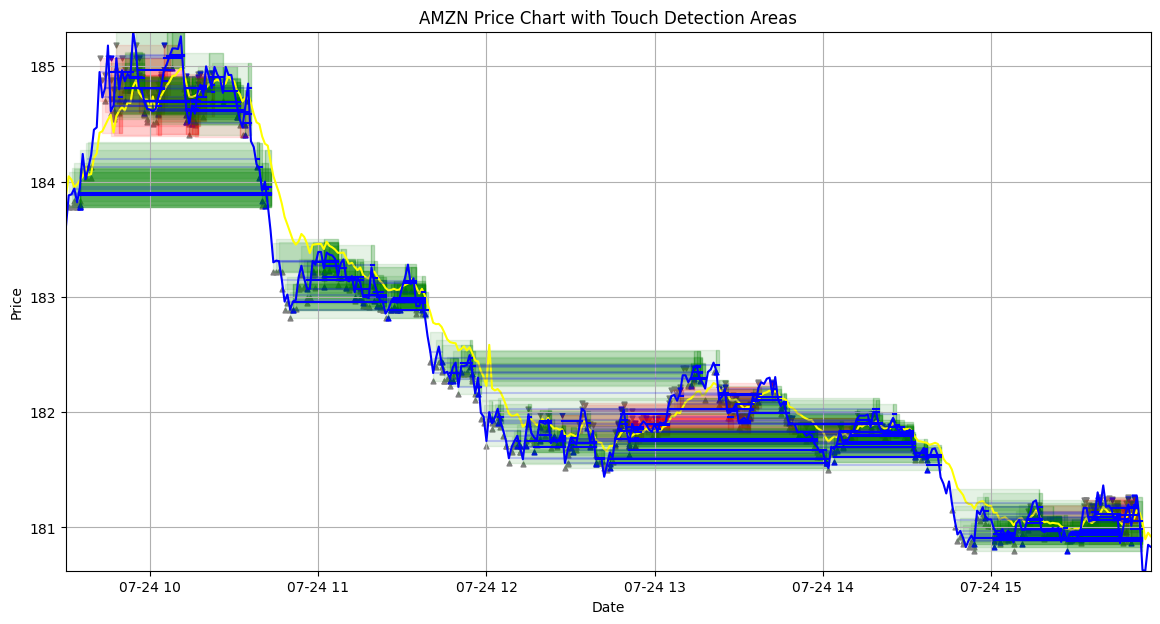

In [29]:
zoom_start_date = start_date
zoom_end_date = end_date
# zoom_end_date = "2024-05-02 11:00:00"
# zoom_start_date = "2024-05-01 09:00:00"
# zoom_end_date =   "2024-05-01 17:00:00"
plot_touch_detection_areas(touch_detection_areas, zoom_start_date, zoom_end_date)

In [30]:
soft_start_time = None
# soft_start_time = '10:30'
soft_end_time = '15:50'
# soft_end_time  = None
# soft_end_time = sell

# # Usage examples:
# print("Both Long and Short:")
# touch_detection_areas = calculate_touch_detection_area(symbol, start_date, end_date, atr_period=15, multiplier=2, min_touches=3, end_time='16:00', \
#     use_median=True, touch_area_width_agg=np.median, use_saved_bars=False, export_bars_path='bars.csv')
backtest_strategy( touch_detection_areas, use_margin=True, do_longs=True, do_shorts=True, times_buying_power=4, \
    min_stop_dist_relative_change_for_partial=0, soft_start_time=soft_start_time, soft_end_time=soft_end_time, export_trades_path='trades_output.csv')

# # print("\nLong only:")
# backtest_strategy( touch_detection_areas, use_margin=True, do_longs=True, do_shorts=False, times_buying_power=2)
  
# # print("\nShort only:")
# backtest_strategy( touch_detection_areas, use_margin=True, do_longs=False, do_shorts=True, times_buying_power=2)


        # print('  ',estimated_entry_cost, balance * overall_margin_multiplier, available_balance)
        # print(max_shares, max_shares_before_costs, cash_needed, fees, estimated_entry_cost)

AMZN is marginable.


100%|██████████| 765/765 [00:00<00:00, 10508.36it/s]

END
Strategy: Long&Short
2024-07-24 04:00:00-04:00 -> 2024-07-24 19:59:00-04:00

Overall Statistics:
Initial Investment: 10000
Final Balance:    12153.4539
Balance change:   21.5345% ***
Baseline change:  -2.0695%
Number of Trades Executed: 37

Total Profit/Loss (including fees): $2153.4539
  Total Profit: $2932.3149
  Total Loss:   $-778.8610
Total Transaction Costs: $42.7700
  Long:  $6.3860
  Short: $36.3840

Borrow Fees: $0.7023
Average Profit/Loss per Trade (including fees): $58.2015
Average Profit/Loss Percentage (ROE) per Trade (including fees): 0.5513%
  for winning trades: 1.7296%
  for losing trades:  -0.3465%
Number of Winning Trades: 16 (1 long, 15 short)
Number of Losing Trades:  21 (11 long, 10 short)
Win Rate: 43.2432%

Margin Usage:
Margin Enabled: Yes
Max Buying Power: 4x
Average Margin Multiplier: 2.0000x
Average Sub Positions per Position: 2.0000
Average Transactions per Position: 15.4595
Trade summary has been exported to trades_output.csv


(np.float64(12153.453934307587),
 37,
 np.float64(21.534539343075867),
 43.24324324324324,
 2.2742,
 np.float64(40.49577235918936),
 np.float64(0.7022792429714505),
 np.float64(42.76997235918936),
 np.float64(2.0),
 np.float64(15.45945945945946),
 np.float64(3.3783783783783785),
 np.float64(4.351351351351352))

In [31]:
# balance, trades_executed, balance_change, win_trades, lose_trades, win_trades / len(trades) * 100
# return balance, trades_executed, balance_change, win_trades / len(trades) * 100, total_entry_transaction_costs, total_exit_transaction_costs, total_stock_borrow_costs, total_transaction_costs

from IPython.utils import io
# results = pd.DataFrame()
results_list = []
# for i in tqdm(list(np.arange(0.1, 2.01, 0.1))):
for i in tqdm(list(np.arange(0.5, 4.01, 0.5))):
    with io.capture_output() as captured:
        balance, trades_executed, balance_change, winrate, entry_costs, exit_costs, borrow_costs, total_costs, avg_sub_pos, avg_transact, avg_partial_entry_count, avg_partial_exit_count = \
            backtest_strategy( touch_detection_areas, use_margin=True, do_longs=True, do_shorts=True, times_buying_power=i, \
                min_stop_dist_relative_change_for_partial=0, soft_end_time=soft_end_time)
            
        newrow = {'times_buying_power':f'{i:.1f}', 'balance':[f'{balance:.6f}'], 'trades_executed':[trades_executed], 'balance_change_per_trade':[f'{balance_change/trades_executed:.6f}'], \
            'winrate':f'{winrate:.6f}', 'entry_costs_per_trade':f'{entry_costs/trades_executed:.6f}', 'exit_costs_per_trade':f'{exit_costs/trades_executed:.6f}', \
                'borrow_costs_per_trade':f'{borrow_costs/trades_executed:.6f}', 'total_costs_per_trade':f'{total_costs/trades_executed:.6f}', \
                    'avg num sub pos created':f'{avg_sub_pos:.2f}', 'avg num transactions':f'{avg_transact:.2f}', \
                        'avg_partial_entry_count':f'{avg_partial_entry_count}', 'avg_partial_exit_count':f'{avg_partial_exit_count}'}
        # results = pd.concat([results, pd.DataFrame.from_dict(newrow)],ignore_index=True)
        results_list.append(pd.DataFrame.from_dict(newrow))
        
results = pd.concat(results_list,ignore_index=True)
results

100%|██████████| 8/8 [00:00<00:00, 10.56it/s]


,times_buying_power,balance,trades_executed,balance_change_per_trade,winrate,entry_costs_per_trade,exit_costs_per_trade,borrow_costs_per_trade,total_costs_per_trade,avg num sub pos created,avg num transactions,avg_partial_entry_count,avg_partial_exit_count
0,0.5,10175.946397,40,0.043987,40.000000,0.006561,0.075479,0.001917,0.082040,1.00,7.08,3.025,4.05
1,1.0,10516.757580,37,0.139664,43.243243,0.014213,0.192859,0.004381,0.207072,1.00,7.68,3.3783783783783785,4.297297297297297
2,1.5,10781.002973,37,0.211082,43.243243,0.021625,0.335514,0.006688,0.357139,1.00,7.70,3.3783783783783785,4.324324324324325
3,2.0,11046.277467,37,0.282778,43.243243,0.029212,0.510802,0.009040,0.540014,1.00,7.70,3.3783783783783785,4.324324324324325
4,2.5,11330.609038,37,0.359624,43.243243,0.037022,0.542490,0.011402,0.579513,2.00,15.41,3.3783783783783785,4.324324324324325
5,3.0,11600.834716,37,0.432658,43.243243,0.044973,0.706104,0.013874,0.751076,2.00,15.41,3.3783783783783785,4.324324324324325
6,3.5,11876.204502,37,0.507082,43.243243,0.053156,0.891015,0.016415,0.944171,2.00,15.46,3.3783783783783785,4.351351351351352
7,4.0,12153.453934,37,0.582015,43.243243,0.061465,1.094480,0.018981,1.155945,2.00,15.46,3.3783783783783785,4.351351351351352


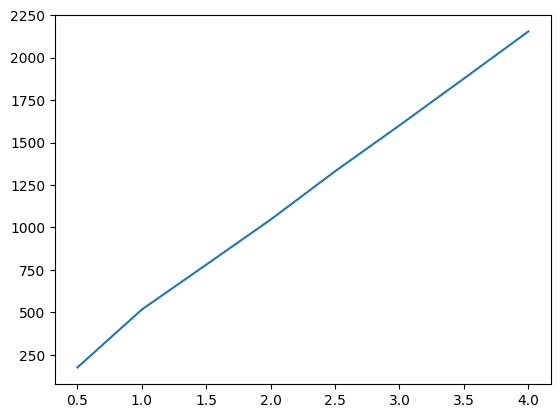

In [32]:
plt.plot(results.times_buying_power.astype(float).to_list(), (results.balance.astype(float)-10000).to_list())

In [33]:
results.to_csv('times_buying_power_test.csv',index=False)

In [34]:
# results.astype(float).describe()